In [1]:
import matplotlib.pyplot as plt
import glob
from typing import List, Tuple
import numpy as np
from IPython.display import display, Markdown

In [2]:
def parse_vtk(lines: List[str]) -> Tuple[int, float, float, np.ndarray, np.ndarray, np.ndarray]:
    """Return body_count, current_time, delta_time, points, masses, velocities from a VTK file."""
    _, current_time, time_step = lines[1].strip().split()

    lines = lines[4:]
    n_bodies = int(lines[0].split()[1])
    lines = lines[1:]

    points = []
    for i in range(n_bodies):
        x, y, z = lines[i].split()
        points.append([float(x), float(y), float(z)])

    # Skip VERTICES data
    lines = lines[(n_bodies+1)*2:]

    # MASS section
    lines = lines[2:]  # skip MASS headers

    masses = []
    for i in range(n_bodies):
        mass = float(lines[i])
        masses.append(mass)

    # Skip MASS data and VELOCITY header
    lines = lines[n_bodies+1:]

    velocities = []
    for i in range(n_bodies):
        vx, vy, vz = lines[i].split()
        velocities.append([float(vx), float(vy), float(vz)])

    return n_bodies, float(current_time), float(time_step), np.array(points), np.array(masses), np.array(velocities)
    

In [3]:
def read_files(pattern: str):
    files = glob.glob(pattern)
    files.sort()
    for file in files:
        with open(file) as fp:
            data = parse_vtk(fp.readlines())
            yield data

In [4]:
data = list(read_files("test_out*"))

In [5]:
def energy_pot(masses: np.ndarray, positions: np.ndarray) -> float:
    gamma: float = 6.6743*10**(-11)
    n_bodies: int = len(masses)
    energy: float = 0.0
    for j in range(n_bodies):
        for i in range(n_bodies):
            if j==i:
                continue
            r = np.linalg.norm(positions[j]-positions[i])
            energy += (masses[i]*masses[j])/r
    return -0.5*gamma*energy


In [6]:
def enery_kin(masses: np.ndarray, velocities: np.ndarray) -> float:
    energy: float = 0.0
    for i in range(len(masses)):
        energy += masses[i]*np.linalg.norm(velocities[i])**2
    return 0.5*energy

In [7]:
def plot_for_files(pattern: str):
    kinetic_energies: List[float] = []
    potential_energies: List[float] = []
    total_energies: List[float] = []
    times: List[float] = []
    dt: float = 0.0
    n_bodies: int = 0
    num_files: int = 0

    for _n_bodies, time, _dt, points, masses, velocities in read_files(pattern):
        num_files += 1
        n_bodies = _n_bodies
        dt = _dt  # stays the same, who cares

        kinetic_energies.append(enery_kin(masses, velocities))
        potential_energies.append(energy_pot(masses, points))
        total_energies.append(kinetic_energies[-1] + potential_energies[-1])
        times.append(time)

    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8, 12))
    axs[0].plot(times, kinetic_energies)
    axs[0].set_title("Kinetic energy")
    axs[1].plot(times, potential_energies)
    axs[1].set_title("Potential energy")
    axs[2].plot(times, total_energies)
    axs[2].set_title("Total energy")

    fig.text(0.5, 0.04, "time[s]", ha="center")
    fig.text(0.04, 0.5, "energy", va="center", rotation="vertical")

    delta_energy = total_energies[-1] - total_energies[0]
    timesteps: int = int(times[-1]//dt)
    display(
        Markdown(rf"## $\Delta$ Energy ${delta_energy}$")
    )
    display(Markdown(rf"### nbodies=${n_bodies}$ timesteps=${timesteps}$ timestep=${dt:.4f}$ every=${timesteps/(num_files-1)}$"))

    plt.show()

## Conservation of Energy

## $\Delta$ Energy $0.08467351442165194$

### nbodies=$128$ timesteps=$100$ timestep=$0.0200$ every=$10.0$

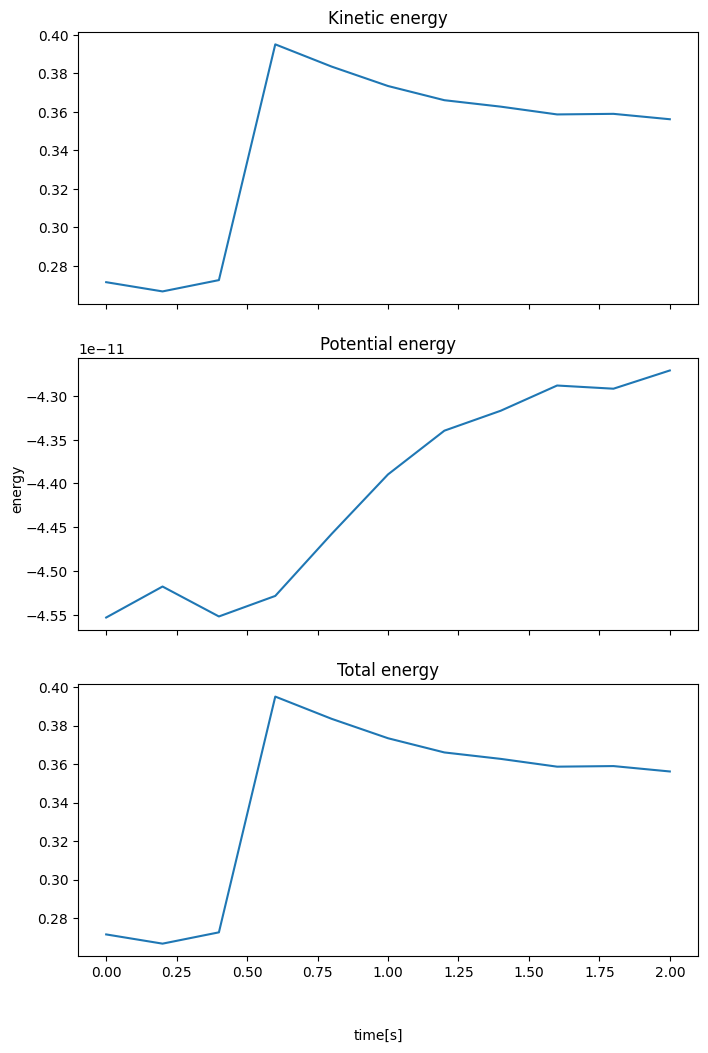

In [8]:
plot_for_files("runs/128/test_out*")

## $\Delta$ Energy $0.01938806290019829$

### nbodies=$1024$ timesteps=$100$ timestep=$0.0200$ every=$10.0$

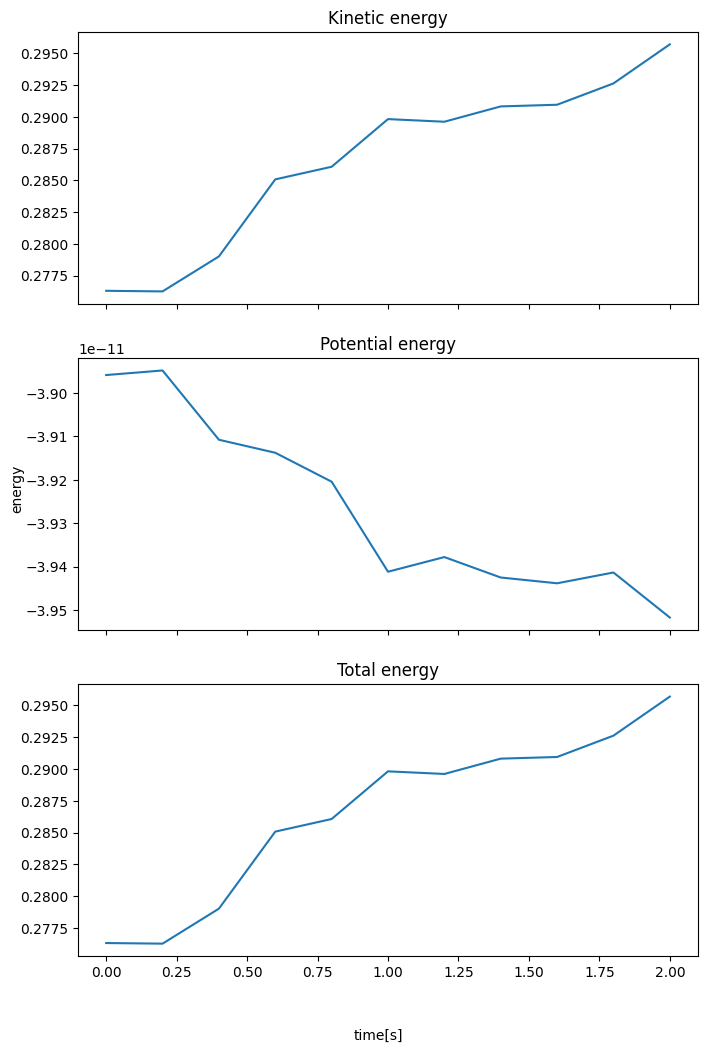

In [9]:
plot_for_files("runs/1024/test_out*")

## $\Delta$ Energy $0.024444094189231935$

### nbodies=$2048$ timesteps=$100$ timestep=$0.0200$ every=$10.0$

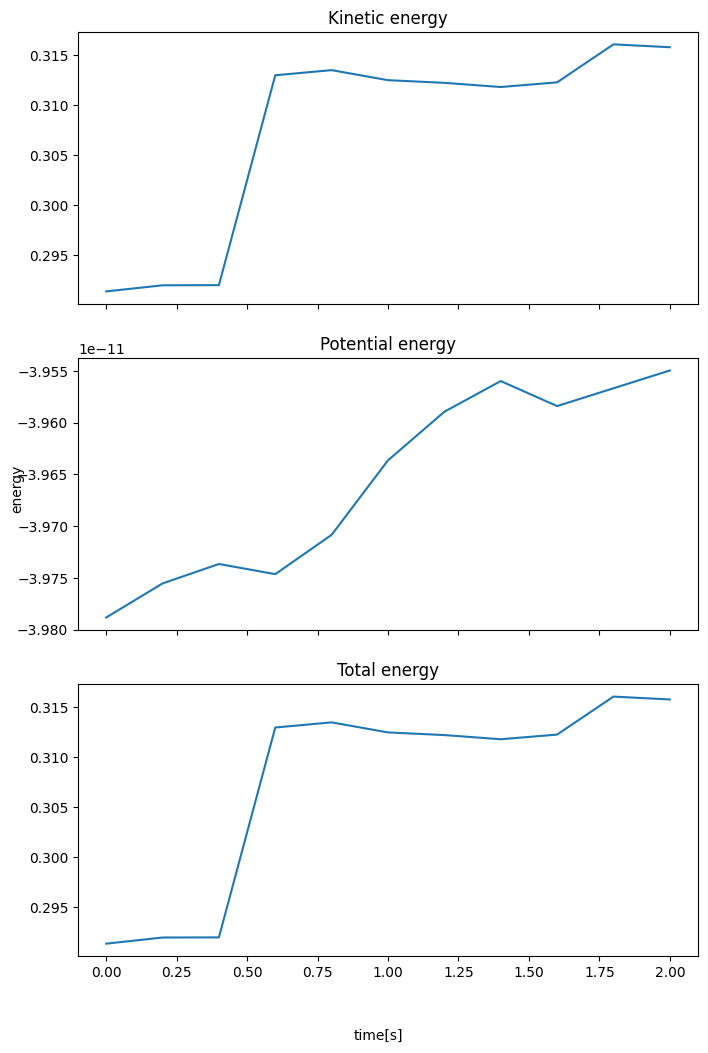

In [10]:
plot_for_files("runs/2048/test_out*")

## Performance Measurements

### Experiments run with varying nbody count, but fixed timestep=0.02 and 500 timesteps.
Compiled with `-O1 -march=native -funroll-loops`, blocksize `B=32`  
Run on Ryzen 5 5600X

In [11]:
nbody_count = [512, 2048, 8192]

vanilla_gflops = [5.23874, 5.24299, 5.20579]
vanilla_runtime = [0.325208, 5.1997, 83.7919]

avx_gflops = [11.5155, 12.3494, 12.6538]
avx_runtime = [0.147947, 2.20756, 34.4721]

intel_4_gflops = [15.8041, 15.9166, 16.124]
intel_4_runtime = [0.1078, 1.7128, 27.053]

intel_2_gflops = [8.06277, 8.07367, 8.07683]
intel_2_runtime = [0.211302, 3.37665 , 54.0068]

our_version_gflops = [8.29166, 8.17853, 8.28888]
our_version_runtime = [0.205469, 3.33336, 52.6251]

our_version_gflops_soa = [13.9349, 14.7133, 14.2824]
our_version_runtime_soa = [0.12226, 1.85288, 30.5413]

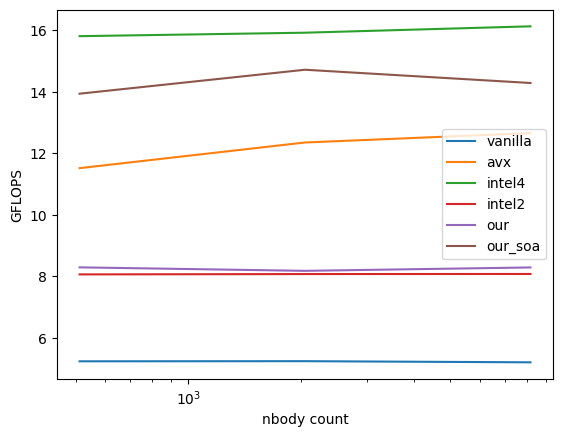

In [12]:
plt.plot(nbody_count, vanilla_gflops, label="vanilla")
plt.plot(nbody_count, avx_gflops, label="avx")
plt.plot(nbody_count, intel_4_gflops, label="intel4")
plt.plot(nbody_count, intel_2_gflops, label="intel2")
plt.plot(nbody_count, our_version_gflops, label="our")
plt.plot(nbody_count, our_version_gflops_soa, label="our_soa")
plt.ylabel("GFLOPS")
plt.xlabel("nbody count")
plt.legend()
plt.xscale("log")
plt.show()


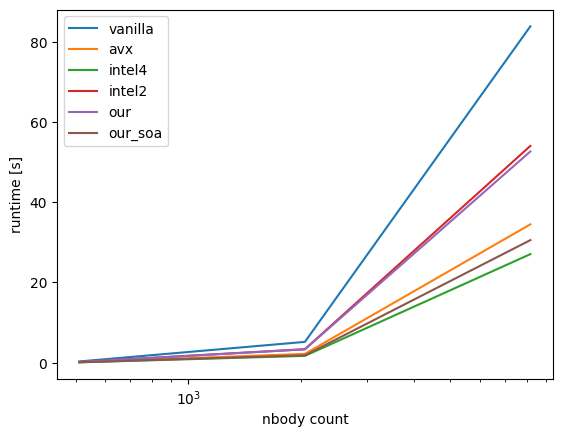

In [13]:
plt.plot(nbody_count, vanilla_runtime, label="vanilla")
plt.plot(nbody_count, avx_runtime, label="avx")
plt.plot(nbody_count, intel_4_runtime, label="intel4")
plt.plot(nbody_count, intel_2_runtime, label="intel2")
plt.plot(nbody_count, our_version_runtime, label="our")
plt.plot(nbody_count, our_version_runtime_soa, label="our_soa")
plt.ylabel("runtime [s]")
plt.xlabel("nbody count")
plt.legend()
plt.xscale("log")
plt.show()